# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [9]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from experiment_utils import MIAExperiment, get_perf
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [6]:
experiments = {}
for i in range(1):
    experiment = MIAExperiment(sampling_condition_dict = 
        {
                'subgroup_col_name': 'ST',
                'n': 1000,
        }, random_state = i,
        shortname = f"Corr_btn_sens_and_output_for_ST_ranging_from_0_to_-0.5_random_state_{i}"
    )
    experiments[experiment.shortname] = experiment

  0%|          | 0/51 [00:00<?, ?it/s]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


  2%|▏         | 1/51 [00:01<00:52,  1.04s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 252, (0, 0): 247, (1, 1): 248, (1, 0): 253}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


  4%|▍         | 2/51 [00:02<00:51,  1.05s/it]

before scaling: 248 125 1.984
after scaling: 125 125 1.0
{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


  6%|▌         | 3/51 [00:03<00:50,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


  8%|▊         | 4/51 [00:04<00:49,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 10%|▉         | 5/51 [00:05<00:48,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 12%|█▏        | 6/51 [00:06<00:47,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 14%|█▎        | 7/51 [00:07<00:46,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 267, (0, 0): 232, (1, 1): 233, (1, 0): 268}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 16%|█▌        | 8/51 [00:08<00:45,  1.05s/it]

before scaling: 233 219 1.0639269406392695
after scaling: 219 219 1.0
{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 18%|█▊        | 9/51 [00:09<00:43,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 20%|█▉        | 10/51 [00:10<00:43,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 22%|██▏       | 11/51 [00:11<00:42,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}}


 24%|██▎       | 12/51 [00:12<00:41,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 279, (0, 0): 220, (1, 1): 221, (1, 0): 280}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {},

 25%|██▌       | 13/51 [00:13<00:40,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {

 27%|██▋       | 14/51 [00:14<00:39,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32:

 29%|██▉       | 15/51 [00:15<00:37,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 2

 31%|███▏      | 16/51 [00:16<00:36,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {}, 18: {}, 19: {},

 33%|███▎      | 17/51 [00:17<00:35,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 35%|███▌      | 18/51 [00:18<00:34,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 37%|███▋      | 19/51 [00:19<00:33,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 39%|███▉      | 20/51 [00:21<00:32,  1.05s/it]

before scaling: 204 163 1.2515337423312884
after scaling: 163 163 1.0
{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1)

 41%|████      | 21/51 [00:22<00:31,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 43%|████▎     | 22/51 [00:23<00:30,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 45%|████▌     | 23/51 [00:24<00:29,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 47%|████▋     | 24/51 [00:25<00:28,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 49%|████▉     | 25/51 [00:26<00:27,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 51%|█████     | 26/51 [00:27<00:26,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 53%|█████▎    | 27/51 [00:28<00:25,  1.05s/it]

before scaling: 187 126 1.4841269841269842
after scaling: 126 126 1.0
{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1)

 55%|█████▍    | 28/51 [00:29<00:24,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 57%|█████▋    | 29/51 [00:30<00:23,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 59%|█████▉    | 30/51 [00:31<00:22,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 61%|██████    | 31/51 [00:32<00:20,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 63%|██████▎   | 32/51 [00:33<00:20,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 65%|██████▍   | 33/51 [00:34<00:19,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 67%|██████▋   | 34/51 [00:35<00:17,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 69%|██████▊   | 35/51 [00:36<00:16,  1.06s/it]

before scaling: 167 120 1.3916666666666666
after scaling: 120 120 1.0
{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1)

 71%|███████   | 36/51 [00:37<00:15,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 73%|███████▎  | 37/51 [00:38<00:14,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 75%|███████▍  | 38/51 [00:40<00:13,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 76%|███████▋  | 39/51 [00:41<00:12,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 78%|███████▊  | 40/51 [00:42<00:11,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 80%|████████  | 41/51 [00:43<00:10,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 82%|████████▏ | 42/51 [00:44<00:09,  1.05s/it]

before scaling: 150 76 1.9736842105263157
after scaling: 76 76 1.0
{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 2

 84%|████████▍ | 43/51 [00:45<00:08,  1.05s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 86%|████████▋ | 44/51 [00:46<00:07,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 88%|████████▊ | 45/51 [00:47<00:06,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 90%|█████████ | 46/51 [00:48<00:05,  1.05s/it]

before scaling: 140 101 1.386138613861386
after scaling: 101 101 1.0
{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1):

 92%|█████████▏| 47/51 [00:49<00:04,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 94%|█████████▍| 48/51 [00:50<00:03,  1.07s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 96%|█████████▌| 49/51 [00:51<00:02,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

 98%|█████████▊| 50/51 [00:52<00:01,  1.06s/it]

{0: {(0, 1): 250, (0, 0): 250, (1, 1): 250, (1, 0): 250}, 1: {(0, 1): 127, (0, 0): 247, (1, 1): 125, (1, 0): 253}, 2: {(0, 1): 254, (0, 0): 245, (1, 1): 246, (1, 0): 255}, 3: {(0, 1): 257, (0, 0): 242, (1, 1): 243, (1, 0): 258}, 4: {(0, 1): 259, (0, 0): 240, (1, 1): 241, (1, 0): 260}, 5: {(0, 1): 262, (0, 0): 237, (1, 1): 238, (1, 0): 263}, 6: {(0, 1): 264, (0, 0): 235, (1, 1): 236, (1, 0): 265}, 7: {(0, 1): 250, (0, 0): 232, (1, 1): 219, (1, 0): 268}, 8: {(0, 1): 269, (0, 0): 230, (1, 1): 231, (1, 0): 270}, 9: {(0, 1): 272, (0, 0): 227, (1, 1): 228, (1, 0): 273}, 10: {(0, 1): 274, (0, 0): 225, (1, 1): 226, (1, 0): 275}, 11: {(0, 1): 276, (0, 0): 223, (1, 1): 224, (1, 0): 277}, 12: {(0, 1): 207, (0, 0): 220, (1, 1): 164, (1, 0): 280}, 13: {(0, 1): 281, (0, 0): 218, (1, 1): 219, (1, 0): 282}, 14: {(0, 1): 284, (0, 0): 215, (1, 1): 216, (1, 0): 285}, 15: {(0, 1): 286, (0, 0): 213, (1, 1): 214, (1, 0): 287}, 16: {(0, 1): 289, (0, 0): 210, (1, 1): 211, (1, 0): 290}, 17: {(0, 1): 291, (0, 0

100%|██████████| 51/51 [00:53<00:00,  1.06s/it]

before scaling: 128 87 1.471264367816092
after scaling: 87 87 1.0


100%|██████████| 51/51 [00:53<00:00,  1.05s/it]


[500, 500, 500, 252, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 469, 500, 500, 500, 500, 500, 500, 500, 500, 500, 371, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 399, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 336, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 359, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 253, 500, 500, 500, 500, 500, 500, 450, 360, 500, 500, 500, 500, 500, 500, 500, 500, 436, 339]


In [37]:
subgroup_vals = [1, 2, 3, 4, 6, 20, 50, 51, 62, 63]
experiment_texas = MIAExperiment(sampling_condition_dict = 
    {
            'subgroup_col_name': 'PAT_STATUS',
            'subgroup_values': subgroup_vals,
            # 'subgroup_values': ['1', '2', '3', '4', '6', '20', '50', '51', '62', '63'],
            'n': 10000
    }, shortname = f"Corr_btn_sens_and_output_for_PAT_STATUS_ranging_from_0_to_-0.5", name='Texas100', sensitive_column='SEX_CODE'
)

  0%|          | 0/10 [00:00<?, ?it/s]

{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}


 10%|█         | 1/10 [00:00<00:03,  2.34it/s]

{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 2375, (0, 0): 2625, (1, 1): 2625, (1, 0): 2375}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}
before scaling: 2625 2188 2375
after scaling: 2188 2188 1.0
before scaling: 1979 1363 1.4519442406456347
after scaling: 1363 1363 1.0


 20%|██        | 2/10 [00:00<00:03,  2.55it/s]

before scaling: 2375 1990 2625
after scaling: 1990 1990 1.0
before scaling: 2199 1170 1.8794871794871795
after scaling: 1170 1170 1.0
{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}


 30%|███       | 3/10 [00:01<00:02,  2.62it/s]

{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {(0, 1): 2125, (0, 0): 2875, (1, 1): 2875, (1, 0): 2125}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}
before scaling: 2875 1347 2125
after scaling: 1347 1347 1.0
before scaling: 995 815 1.2208588957055215
after scaling: 815 815 1.0


 40%|████      | 4/10 [00:01<00:02,  2.60it/s]

before scaling: 2125 1800 2875
after scaling: 1800 1800 1.0
before scaling: 2435 1295 1.8803088803088803
after scaling: 1295 1295 1.0
{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {(0, 1): 957, (0, 0): 1103, (1, 1): 1295, (1, 0): 815}, 4: {(0, 1): 2000, (0, 0): 3000, (1, 1): 3000, (1, 0): 2000}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}}


 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {(0, 1): 957, (0, 0): 1103, (1, 1): 1295, (1, 0): 815}, 4: {(0, 1): 2000, (0, 0): 3000, (1, 1): 3000, (1, 0): 2000}, 5: {(0, 1): 1875, (0, 0): 3125, (1, 1): 3125, (1, 0): 1875}, 6: {}, 7: {}, 8: {}, 9: {}}
before scaling: 1875 1492 1.2567024128686326
after scaling: 1492 1492 1.0


 60%|██████    | 6/10 [00:02<00:01,  2.63it/s]

before scaling: 3125 1789 1.74678591391839
after scaling: 1789 1789 1.0
{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {(0, 1): 957, (0, 0): 1103, (1, 1): 1295, (1, 0): 815}, 4: {(0, 1): 2000, (0, 0): 3000, (1, 1): 3000, (1, 0): 2000}, 5: {(0, 1): 1073, (0, 0): 2486, (1, 1): 1789, (1, 0): 1492}, 6: {(0, 1): 1750, (0, 0): 3250, (1, 1): 3250, (1, 0): 1750}, 7: {}, 8: {}, 9: {}}
before scaling: 3250 1346 1750
after scaling: 1346 1346 1.0
before scaling: 724 693 1.0447330447330447
after scaling: 693 693 1.0


 70%|███████   | 7/10 [00:02<00:01,  2.55it/s]

before scaling: 1750 1568 3250
after scaling: 1568 1568 1.0
before scaling: 2912 924 3.1515151515151514
after scaling: 924 924 1.0
{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {(0, 1): 957, (0, 0): 1103, (1, 1): 1295, (1, 0): 815}, 4: {(0, 1): 2000, (0, 0): 3000, (1, 1): 3000, (1, 0): 2000}, 5: {(0, 1): 1073, (0, 0): 2486, (1, 1): 1789, (1, 0): 1492}, 6: {(0, 1): 497, (0, 0): 1288, (1, 1): 924, (1, 0): 693}, 7: {(0, 1): 1624, (0, 0): 3375, (1, 1): 3376, (1, 0): 1625}, 8: {}, 9: {}}
before scaling: 3375 1548 1625
after scaling: 1548 1548 1.0
before scaling: 745 640 1.1640625
after scaling: 640 640 1.0


 80%|████████  | 8/10 [00:03<00:00,  2.59it/s]

before scaling: 3376 963 3.5057113187954307
after scaling: 963 963 1.0
{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {(0, 1): 957, (0, 0): 1103, (1, 1): 1295, (1, 0): 815}, 4: {(0, 1): 2000, (0, 0): 3000, (1, 1): 3000, (1, 0): 2000}, 5: {(0, 1): 1073, (0, 0): 2486, (1, 1): 1789, (1, 0): 1492}, 6: {(0, 1): 497, (0, 0): 1288, (1, 1): 924, (1, 0): 693}, 7: {(0, 1): 463, (0, 0): 1329, (1, 1): 963, (1, 0): 640}, 8: {(0, 1): 1500, (0, 0): 3500, (1, 1): 3500, (1, 0): 1500}, 9: {}}


 90%|█████████ | 9/10 [00:03<00:00,  2.62it/s]

{0: {(0, 1): 2500, (0, 0): 2500, (1, 1): 2500, (1, 0): 2500}, 1: {(0, 1): 1058, (0, 0): 1506, (1, 1): 1170, (1, 0): 1363}, 2: {(0, 1): 2250, (0, 0): 2750, (1, 1): 2750, (1, 0): 2250}, 3: {(0, 1): 957, (0, 0): 1103, (1, 1): 1295, (1, 0): 815}, 4: {(0, 1): 2000, (0, 0): 3000, (1, 1): 3000, (1, 0): 2000}, 5: {(0, 1): 1073, (0, 0): 2486, (1, 1): 1789, (1, 0): 1492}, 6: {(0, 1): 497, (0, 0): 1288, (1, 1): 924, (1, 0): 693}, 7: {(0, 1): 463, (0, 0): 1329, (1, 1): 963, (1, 0): 640}, 8: {(0, 1): 1500, (0, 0): 3500, (1, 1): 3500, (1, 0): 1500}, 9: {(0, 1): 1375, (0, 0): 3625, (1, 1): 3625, (1, 0): 1375}}


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

before scaling: 3625 2288 1.5843531468531469
after scaling: 2288 2288 1.0
[5000, 5000, 2869, 2228, 5000, 5000, 1918, 2252, 5000, 5000, 3978, 2862, 1981, 1421, 1969, 1426, 5000, 5000, 5000, 3155]


In [7]:
save_model = True

print(f"Training classifier for experiment: {experiment}")
try:
    experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
    print(f"Loaded classifier for experiment from file: {experiment}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment.clf = model_utils.get_model(max_iter=500)
    experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_subgroup_col_name_ST_n_1000_rs0


In [38]:
save_model = False

print(f"Training classifier for experiment: {experiment_texas}")
try:
    experiment_texas.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment_texas.ds.ds.filenameroot}_target_modell.pkl')
    print(f"Loaded classifier for experiment from file: {experiment_texas}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment_texas.clf = model_utils.get_model(max_iter=500)
    experiment_texas.clf.fit(experiment_texas.X_train, experiment_texas.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment_texas.clf, f'<PATH_TO_MODEL>/{experiment_texas.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Texas100_subgroup_col_name_PAT_STATUS_subgroup_values_[1, 2, 3, 4, 6, 20, 50, 51, 62, 63]_n_10000_rs42


In [115]:
def get_group_by_group_evaluation(experiment, subgroup_col_name='ST', subgroup_vals=[]):
    experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_tr, experiment.clf)
    sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    case_2_indices = case_indices[2]
    experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
    experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
    experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]
    experiment.sens_pred_CSMIA = sens_pred
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)

    conditions = [{}] + [{subgroup_col_name: i} for i in subgroup_vals]
    # num_of_samples_per_group_in_aux = 100 if experiment.ds.ds.name == 'Census19' else 500
    aux_indices = np.concatenate([get_indices_by_group_condition(experiment.X_test, condition).to_series().sample(frac=0.02, random_state=42, replace=False).index for condition in conditions[1:]])
    X_aux, y_aux = experiment.X_test.copy().loc[aux_indices].reset_index(drop=True), experiment.y_te[aux_indices]
    sub_size_df = get_CSMIA_case_by_case_results(experiment.clf, X_aux, y_aux, experiment.ds, subgroup_col_name, metric='accuracy', sensitive_col_name=None, subgroup_vals=subgroup_vals)
    baseline_res = sub_size_df.loc['Case All Cases'].to_numpy()
    baseline_res = np.array([baseline_res[-1]]+[get_perf(r) for r in baseline_res[:-1]])

    experiment.y_te_pred = experiment.clf.predict(experiment.X_test)[:,1]

    correlation_vs_ang_diff = {}
    for i, condition in enumerate(conditions):
        fcondition = f'{condition}'
        correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
        indices = get_indices_by_group_condition(experiment.X_case_2, condition)
        angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
        correlation_vs_ang_diff[fcondition] = {}
        correlation_vs_ang_diff[fcondition]['correlation'] = correlation
        correlation_vs_ang_diff[fcondition]['angular_difference'] = -angular_difference
        indices = get_indices_by_group_condition(experiment.X_train, condition)
        correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = 100 * accuracy_score(experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices])
        correlation_vs_ang_diff[fcondition]['LOMIA_attack_accuracy'] = 100 * accuracy_score(experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices])
        indices_2 = get_indices_by_group_condition(experiment.X_test, condition)
        correlation_vs_ang_diff[fcondition]['model_accuracy'] = 100 * accuracy_score(experiment.y_te[indices_2].ravel(), experiment.y_te_pred[indices_2])
        correlation_vs_ang_diff[fcondition]['baseline_attack_accuracy'] = baseline_res[i]

    correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

    return correlation_vs_ang_diff_df



In [118]:
correlation_vs_ang_diff_df = get_group_by_group_evaluation(experiment, subgroup_col_name='ST', subgroup_vals=list(range(51)))

In [116]:
correlation_vs_ang_diff_df_texas = get_group_by_group_evaluation(experiment_texas, subgroup_col_name='PAT_STATUS', subgroup_vals=subgroup_vals)

In [82]:
def scatter_plot(correlation_vs_ang_diff_df, x_axis, y_axis, fontsize=16):
    arr = correlation_vs_ang_diff_df[[x_axis['name'], y_axis['name']]].to_numpy()
    x_values, y_values = arr[:, 0], arr[:, 1]

    # Creating the scatter plot
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.scatter(x_values, y_values, color='black', alpha=0.75, marker='x', s=75)
    # plt.title('Scatter Plot of Correlation vs Angular Difference')
    plt.xlabel(x_axis['label'], fontsize=fontsize)
    plt.ylabel(y_axis['label'], fontsize=fontsize)
    ax.set_xticks(x_axis['xticks'])
    ax.set_xticklabels([f'{i:.1f}' for i in x_axis['xticks']], fontsize=fontsize)
    ax.set_yticks(y_axis['yticks'])
    ax.set_yticklabels([f'{i:.0f}%' for i in y_axis['yticks']], fontsize=fontsize)
    # plt.xlim(-0.5, 0.025)
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # sns.despine()
    plt.show()

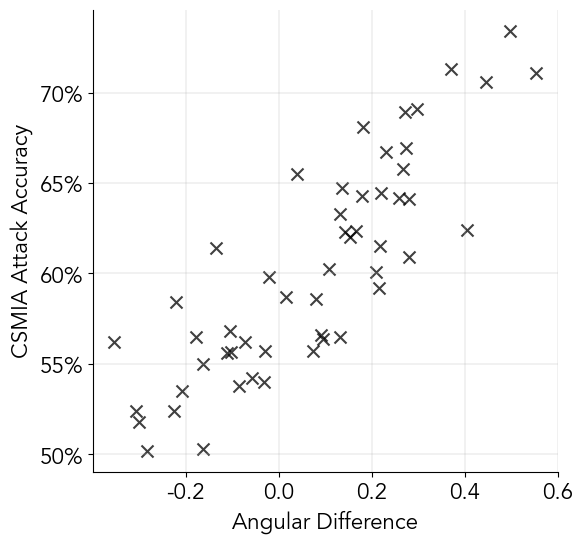

In [83]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'angular_difference', 'label': 'Angular Difference', 'xticks': np.arange(-0.2, 0.7, 0.2)},
    y_axis={'name': 'CSMIA_attack_accuracy', 'label': 'CSMIA Attack Accuracy', 'yticks': np.arange(50, 75, 5)}
    )

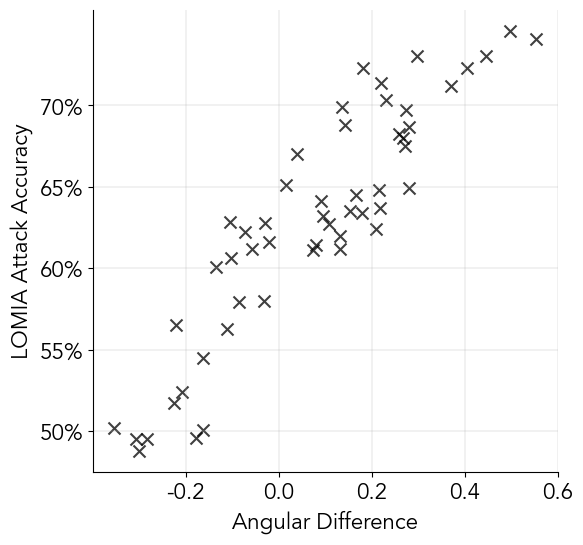

In [84]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'angular_difference', 'label': 'Angular Difference', 'xticks': np.arange(-0.2, 0.7, 0.2)},
    y_axis={'name': 'LOMIA_attack_accuracy', 'label': 'LOMIA Attack Accuracy', 'yticks': np.arange(50, 75, 5)}
    )

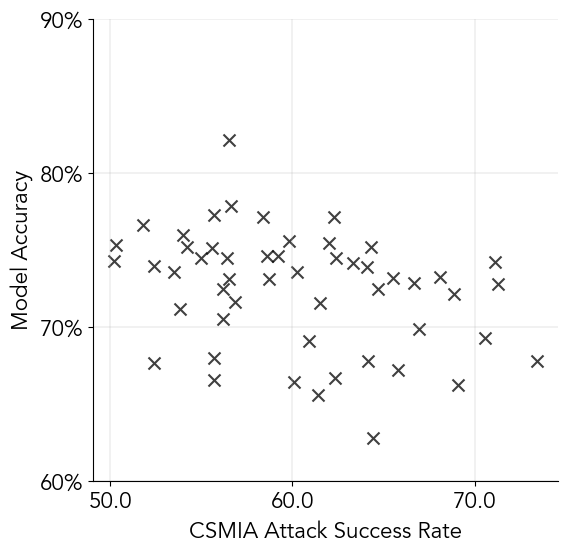

In [85]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'CSMIA_attack_accuracy', 'label': 'CSMIA Attack Success Rate', 'xticks': np.arange(50, 80, 10)},
    y_axis={'name': 'model_accuracy', 'label': 'Model Accuracy', 'yticks': np.arange(60, 100, 10)}
    )

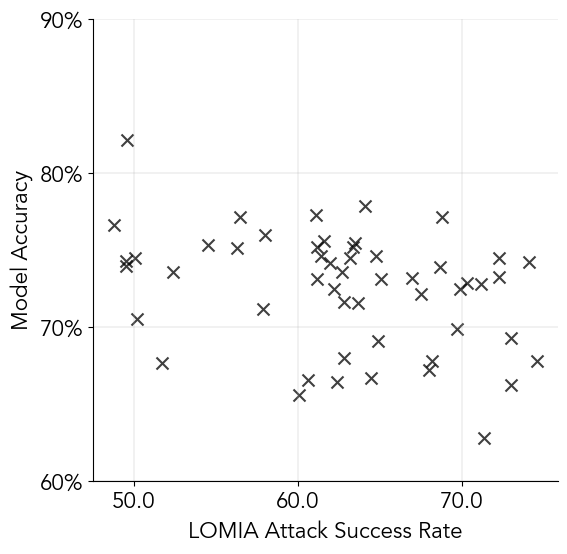

In [86]:
scatter_plot(
    correlation_vs_ang_diff_df,
    x_axis={'name': 'LOMIA_attack_accuracy', 'label': 'LOMIA Attack Success Rate', 'xticks': np.arange(50, 80, 10)},
    y_axis={'name': 'model_accuracy', 'label': 'Model Accuracy', 'yticks': np.arange(60, 100, 10)}
    )

In [87]:
def get_ranking_quality(correlation_vs_ang_diff_df):
    attacks = ['CSMIA', 'LOMIA']
    metrics = [kendalltau, spearmanr]
    metric_name_dict = {
        kendalltau: 'Kendall Tau',
        spearmanr: 'Spearman R'
    }

    ranking_perf_dict = {}
    for attack in attacks:
        ranking_perf_dict[attack] = {}
        for metric in metrics:
            ranking_perf_dict[attack][metric_name_dict[metric]] = {}

            for dia in ['angular_difference', 'baseline_attack_accuracy']:
                ranking_perf = metric(correlation_vs_ang_diff_df[[f'{attack}_attack_accuracy']].to_numpy(), correlation_vs_ang_diff_df[[dia]].to_numpy())
                ranking_perf_dict[attack][metric_name_dict[metric]][dia] = f'{round(ranking_perf.statistic, 4)} ({ranking_perf.pvalue:.2e})'

    return ranking_perf_dict

In [119]:
get_ranking_quality(correlation_vs_ang_diff_df)

{'CSMIA': {'Kendall Tau': {'angular_difference': '0.6742 (1.82e-12)',
   'baseline_attack_accuracy': '0.0275 (7.76e-01)'},
  'Spearman R': {'angular_difference': '0.8588 (3.86e-16)',
   'baseline_attack_accuracy': '0.0372 (7.93e-01)'}},
 'LOMIA': {'Kendall Tau': {'angular_difference': '0.7462 (6.32e-15)',
   'baseline_attack_accuracy': '0.0711 (4.62e-01)'},
  'Spearman R': {'angular_difference': '0.9095 (1.06e-20)',
   'baseline_attack_accuracy': '0.0988 (4.86e-01)'}}}

In [117]:
get_ranking_quality(correlation_vs_ang_diff_df_texas)

{'CSMIA': {'Kendall Tau': {'angular_difference': '-0.6364 (5.71e-03)',
   'baseline_attack_accuracy': '-0.187 (4.31e-01)'},
  'Spearman R': {'angular_difference': '-0.8 (3.11e-03)',
   'baseline_attack_accuracy': '-0.3028 (3.65e-01)'}},
 'LOMIA': {'Kendall Tau': {'angular_difference': '-0.6727 (3.11e-03)',
   'baseline_attack_accuracy': '-0.374 (1.15e-01)'},
  'Spearman R': {'angular_difference': '-0.8636 (6.12e-04)',
   'baseline_attack_accuracy': '-0.5046 (1.13e-01)'}}}